## Запустить seq2seq, seq2seq с внимаием для перевода русских слов + описать наблюдения по качеству

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

In [3]:
batch_size = 64
epochs = 60
latent_dim = 256
num_samples = 10000
data_path = 'data/rus-eng/rus.txt'

In [4]:
# Собираем из текстов токены и делаем pne-hot вектора на каждый токен

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [6]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [7]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [8]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())




Epoch 1/60
125/125 [==============================] - 4s 30ms/step - loss: 1.1247 - accuracy: 0.7742 - val_loss: 0.9280 - val_accuracy: 0.7592
Epoch 2/60
125/125 [==============================] - 3s 26ms/step - loss: 0.7317 - accuracy: 0.8035 - val_loss: 0.7834 - val_accuracy: 0.7927
Epoch 3/60
125/125 [==============================] - 3s 25ms/step - loss: 0.7264 - accuracy: 0.8107 - val_loss: 0.7434 - val_accuracy: 0.8062
Epoch 4/60
125/125 [==============================] - 3s 25ms/step - loss: 0.6114 - accuracy: 0.8367 - val_loss: 0.6717 - val_accuracy: 0.8136
Epoch 5/60
125/125 [==============================] - 3s 25ms/step - loss: 0.5610 - accuracy: 0.8443 - val_loss: 0.6352 - val_accuracy: 0.8200
Epoch 6/60
125/125 [==============================] - 3s 25ms/step - loss: 0.5321 - accuracy: 0.8495 - val_loss: 0.6057 - val_accuracy: 0.8271
Epoch 7/60
125/125 [==============================] - 3s 26ms/step - loss: 0.5120 - accuracy: 0.8539 - val_loss: 0.5951 - val_accuracy: 0.8281

125/125 [==============================] - 4s 31ms/step - loss: 0.1505 - accuracy: 0.9547 - val_loss: 0.4630 - val_accuracy: 0.8853
Epoch 58/60
125/125 [==============================] - 3s 25ms/step - loss: 0.1458 - accuracy: 0.9562 - val_loss: 0.4639 - val_accuracy: 0.8850
Epoch 59/60
125/125 [==============================] - 3s 25ms/step - loss: 0.1419 - accuracy: 0.9574 - val_loss: 0.4675 - val_accuracy: 0.8863
Epoch 60/60
125/125 [==============================] - 3s 26ms/step - loss: 0.1394 - accuracy: 0.9577 - val_loss: 0.4709 - val_accuracy: 0.8852


In [9]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Иди.

-
Input sentence: Go.
Decoded sentence: Иди.

-
Input sentence: Go.
Decoded sentence: Иди.

-
Input sentence: Hi.
Decoded sentence: Здрасте.

-
Input sentence: Hi.
Decoded sentence: Здрасте.

-
Input sentence: Hi.
Decoded sentence: Здрасте.

-
Input sentence: Hi.
Decoded sentence: Здрасте.

-
Input sentence: Hi.
Decoded sentence: Здрасте.

-
Input sentence: Run!
Decoded sentence: Беги!

-
Input sentence: Run!
Decoded sentence: Беги!



In [8]:
import re
import tensorflow.compat.v1 as tf
data_path = 'data/rus-eng/rus.txt'
num_samples = 10000

tf.enable_eager_execution()

input_texts = []
target_texts = []

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

def preprocess_sentence_rus(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^а-яА-Я?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence_rus(target_text))

In [9]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [10]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [11]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [15]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [16]:
EPOCHS = 40
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 1.6721
Epoch 2 Loss 1.2604
Epoch 3 Loss 1.0817
Epoch 4 Loss 0.9324
Epoch 5 Loss 0.8050
Epoch 6 Loss 0.6805
Epoch 7 Loss 0.5662
Epoch 8 Loss 0.4664
Epoch 9 Loss 0.3820
Epoch 10 Loss 0.3206
Epoch 11 Loss 0.2760
Epoch 12 Loss 0.2418
Epoch 13 Loss 0.2177
Epoch 14 Loss 0.2002
Epoch 15 Loss 0.1866
Epoch 16 Loss 0.1784
Epoch 17 Loss 0.1698
Epoch 18 Loss 0.1631
Epoch 19 Loss 0.1582
Epoch 20 Loss 0.1542
Epoch 21 Loss 0.1493
Epoch 22 Loss 0.1455
Epoch 23 Loss 0.1414
Epoch 24 Loss 0.1385
Epoch 25 Loss 0.1368
Epoch 26 Loss 0.1345
Epoch 27 Loss 0.1332
Epoch 28 Loss 0.1321
Epoch 29 Loss 0.1305
Epoch 30 Loss 0.1283
Epoch 31 Loss 0.1274
Epoch 32 Loss 0.1263
Epoch 33 Loss 0.1260
Epoch 34 Loss 0.1290
Epoch 35 Loss 0.1242
Epoch 36 Loss 0.1217
Epoch 37 Loss 0.1224
Epoch 38 Loss 0.1193
Epoch 39 Loss 0.1184
Epoch 40 Loss 0.1177


In [17]:
input_texts[:10]

['<start> Go . <end>',
 '<start> Go . <end>',
 '<start> Go . <end>',
 '<start> Hi . <end>',
 '<start> Hi . <end>',
 '<start> Hi . <end>',
 '<start> Hi . <end>',
 '<start> Hi . <end>',
 '<start> Run ! <end>',
 '<start> Run ! <end>']

In [18]:
target_texts[:10]

['<start> Марш ! <end>',
 '<start> Иди . <end>',
 '<start> Идите . <end>',
 '<start> Здравствуйте . <end>',
 '<start> Привет ! <end>',
 '<start> Хай . <end>',
 '<start> Здрасте . <end>',
 '<start> Здоро во ! <end>',
 '<start> Беги ! <end>',
 '<start> Бегите ! <end>']

Некоторые украденные функции для оценки

In [21]:
import matplotlib.pyplot as plt
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> good morning . <end>
Predicted translation: доброе утро . <end> 


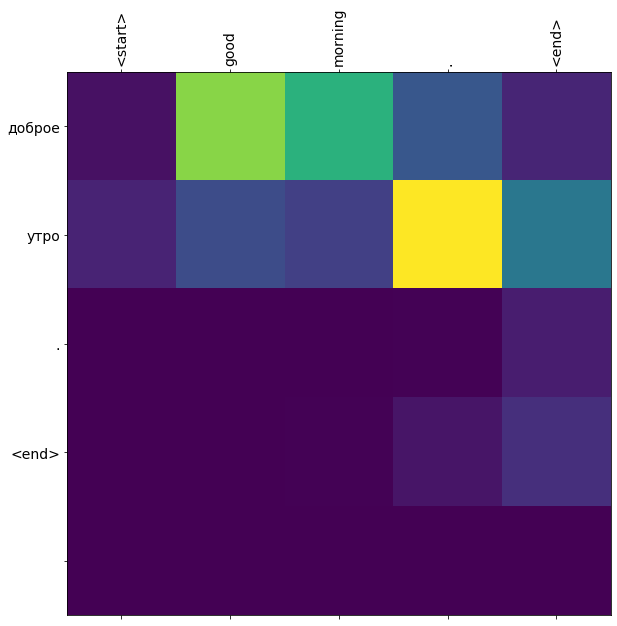

In [22]:
 translate(u'good morning .')

Все работает, но если бить без точки то некоректно переводит (это из-за обучающего dataseta. надобы поправить, но...).

## переделать генерацию текста по символам в генерацию по словам

In [23]:
path_to_file = 'evgenyi_onegin.txt'

In [24]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 286984 characters


In [25]:
print(text[:250])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                       


In [26]:
text_mas = re.findall(r',|\.|\s|[а-яА-Я]+', text)

In [27]:
# The unique characters in the file
vocab = sorted(set(text_mas))
print('{} unique characters'.format(len(vocab)))

9098 unique characters


In [28]:
# Creating a mapping from unique characters to indices
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in text_mas])

In [30]:
text_as_int[100:140], text_mas[100:140], len(text_as_int), len(text)

(array([   1,    1,    1,    1,    1,    1,  925,    1, 5061,    1, 3139,
           1, 7280,    1, 3752,    2,    0,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1]),
 [' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'Не',
  ' ',
  'мысля',
  ' ',
  'гордый',
  ' ',
  'свет',
  ' ',
  'забавить',
  ',',
  '\n',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' '],
 195435,
 286984)

In [31]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2word[i.numpy()])

Александр
 
Сергеевич
 
Пушкин


In [32]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2word[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                                Роман в стихах\n\n                   '
'     Не мысля гордый свет забавить,\n                        Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                    '
'    Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Святой исполненной мечты,\n                        Поэзии живой '
'и ясной,\n                        Высоких дум и простоты\n                        Но так и быть  рукой пристрастной\n                        Прими собранье'
' пестрых глав,\n                        Полусмешных, полупечальных,\n                        Простонародных, идеальных,\n                        Небрежный плод моих забав,\n  '


In [33]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [34]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2word[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2word[target_example.numpy()])))

Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                                Роман в стихах\n\n                  '
Target data: ' Сергеевич Пушкин\n\n                                Евгений Онегин\n                                Роман в стихах\n\n                   '


In [35]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [36]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [37]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [38]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [39]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 9098) # (batch_size, sequence_length, vocab_size)


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           2329088   
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          3935232   
_________________________________________________________________
dense_5 (Dense)              (64, None, 9098)          9325450   
Total params: 15,589,770
Trainable params: 15,589,770
Non-trainable params: 0
_________________________________________________________________


In [41]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [42]:
print("Input: \n", repr("".join(idx2word[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2word[sampled_indices ])))

Input: 
 '            Любовник Юлии Вольмар,\n                        МалекАдель и де Линар,\n                        И Вертер, мученик мятежный,\n             '

Next Char Predictions: 
 'поблеклыйусыпляюЛеснаяводилРегулклонятшепталадрузьянежныйвышелдетиБалвласыпосетиливпросакнебомзавидимпокойпрадедовнаслажденьембудучиписатьжурчаньеувиделавешниеВозможноразогналиежегодноОчаровательныхПетушковВсюЧужогооблитсанкиОтметкунивыблагосклонныймладойтеперьзлословиемДелилигороюСтаканвсяответДавайсмелыйскукоюсвекровьдавилСадиначалевпервыебогатынемудреномечтаньеглазамразыгранныйнагоняястаринаПриготовляетсябезыменноюнеугомоннотяжбыЗаветныйволжскихГремучийискрамиприемныймужчинамиСказалсупругурытьсяЛинарсвоевольныйвысшембезотрадночиститьвосторговмутнымиокаменетьбьютпылкихпокинутьзевнулстебелекбурюпредсказаньясдуруостротызнанийщадитькняжнывысшийПчелаМладыхужимокбранятИдетДушеньки'


In [43]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 9098)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       9.115717


In [44]:
model.compile(optimizer='adam', loss=loss)

In [45]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [46]:
EPOCHS = 60

In [47]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/60
30/30 [==============================] - 22s 749ms/step - loss: 2.7018
Epoch 2/60
30/30 [==============================] - 22s 730ms/step - loss: 1.6693
Epoch 3/60
30/30 [==============================] - 22s 741ms/step - loss: 1.6566
Epoch 4/60
30/30 [==============================] - 23s 760ms/step - loss: 1.6558
Epoch 5/60
30/30 [==============================] - 23s 768ms/step - loss: 1.6558
Epoch 6/60
30/30 [==============================] - 23s 776ms/step - loss: 1.6531
Epoch 7/60
30/30 [==============================] - 23s 780ms/step - loss: 1.6550
Epoch 8/60
30/30 [==============================] - 23s 780ms/step - loss: 1.6552
Epoch 9/60
30/30 [==============================] - 24s 797ms/step - loss: 1.6531
Epoch 10/60
30/30 [==============================] - 24s 785ms/step - loss: 1.6351
Epoch 11/60
30/30 [==============================] - 24s 791ms/step - loss: 1.5647
Epoch 12/60
30/30 [==============================] - 24s 801ms/step - loss: 1.4843
Epoch 13/60
3

In [48]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_60'

In [49]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            2329088   
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           3935232   
_________________________________________________________________
dense_6 (Dense)              (1, None, 9098)           9325450   
Total params: 15,589,770
Trainable params: 15,589,770
Non-trainable params: 0
_________________________________________________________________


In [55]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [word2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id])
        
    start_string = ''.join(start_string)
    return (start_string + ''.join(text_generated))
    #return text_generated

In [56]:
print(generate_text(model, start_string=['Уж', ' ', 'месяц', ' ', 'был', ' ']))

Уж месяц был ли, конечно, раскаяньем Расин,
             томный пел залу гондоле
 богу убит
             Они, сплетни, стеклянным Киприды,
       До глухой, няня, раздетый,
           Пойду тошно, которой журналы,
              Однако же, скучал, полдень и страданье
         с засмеяться наша бане
                    Вновь вместе, прощальный кременьплоходомойто же тот, Таня, ль
    Забыт. он, многом
               Татьяну равнодушных
            К Отца неземной,
       То мысль слезами небосклоне

            Приготовляется дома сонным привета,
        Ни цевницы вас привела
        Уж их трещитокруженразлучило.

               О некогда молчаливом женой.

           .

       Но вдруг уж знать,
              Поутру живо вседневные устала
           Держу ждет свет порукой,
               ПустыннымА за тайною мадригальных
          Он слыхали, блаженные пыльной очах,
     Приготовляется молвил искусства,
                    Потолковать жил утром модной
    нежно уныние..


По буквам лучше было